In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights

In [3]:
#https://medium.com/@evodopives/demystifying-cnn-decisions-a-practical-gradcam-implementation-in-pytorch-2d5692707b0d

features = None 
grads = None

# Forward hook: capture the output (feature maps)
def forward_hook(module, input, output):
    global features
    features = output.detach()

# Backward hook: capture the gradients from the output
def backward_hook(module, grad_in, grad_out):
    global grads
    grads = grad_out[0].detach()

In [5]:
#

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.eval()

# Identify the last convolutional layer
target_layer = model.layer4[-1]

target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [11]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
img_path = '/project/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07461 - Copy.jpg' 
img = Image.open(img_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

In [8]:
output = model(input_tensor)

# Choose a class index (e.g., for demonstration)
class_idx = 0
score = output[0, class_idx]

model.zero_grad()
score.backward()

In [9]:
# Compute weights: global average pooling over gradients
weights = torch.mean(grads, dim=(2, 3))  # Shape: [batch, channels]

# Compute the weighted combination of feature maps
cam = torch.sum(weights.unsqueeze(-1).unsqueeze(-1) * features, dim=1)

cam = F.relu(cam)

# Normalize the CAM to [0, 1]
cam = cam - cam.min()
cam = cam / cam.max()

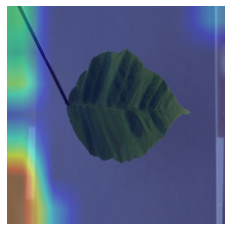

In [10]:
cam_np = cam[0].cpu().numpy()
cam_np = cv2.resize(cam_np, (224, 224))
cam_np = np.uint8(255 * cam_np)

# Apply a colormap (JET) and convert color channels from BGR to RGB
heatmap = cv2.applyColorMap(cam_np, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

img_np = np.array(img.resize((224, 224)))

# Overlay: 40% heatmap and 60% original image
overlay = heatmap * 0.4 + img_np * 0.6
overlay = np.uint8(np.clip(overlay, 0, 255))

plt.imshow(overlay)
plt.axis('off')
plt.show()

In [ ]:
#Vikram code
#predict_additional.py

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

cam = GradCAM(model=model, target_layers=model.grad_cam_layer)

def run_image(
    img: Image.Image,
    model: PretrainedModel,
    preprocessing: v2.Compose,
    cam: GradCAM,
) -> list[float]:
    orig_img = pil_to_tensor(img)
    _, h, w = orig_img.shape
    img = orig_img[None]
    img = preprocessing(img)
    gradcam_output = cam(img)[0]
    gradcam_output = cv2.resize(gradcam_output, (w, h))
    gradcam_output = show_cam_on_image(
        orig_img.numpy().transpose((1, 2, 0)) / 255.0,
        gradcam_output,
        use_rgb=True,
        image_weight=0.7,
    )
    logits = model(img.to(device))
    return logits[0].tolist(), gradcam_output